In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, GRU, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv('dataset.csv') #dataset.csv is expected to contain data in a tabular format,
input_texts = data['English words/sentences'].values
target_texts = data['French words/sentences'].values

# Cut the data to work faster, for now!
input_texts = input_texts[:5000]
target_texts = target_texts[:5000]

In [3]:
input_texts.shape, target_texts.shape

((5000,), (5000,))

In [4]:
eng_tokenizer = Tokenizer(filters='') #Keras Tokenizer for models that require numeric input, because it simplifies text data by converting it into sequences of integers
eng_tokenizer.fit_on_texts(input_texts) #Tokenizer scans through all the sentences in input_texts and assigns a unique integer to each word, After this step, the tokenizer will have created a word_index attribute, which is a dictionary mapping each word to a unique integer
eng_sequences = eng_tokenizer.texts_to_sequences(input_texts) #I love cats" might be converted into [2, 5, 12], where 2, 5, and 12,  based on the word_index, eng_sequences is now a list of lists
eng_vocab_size = len(eng_tokenizer.word_index) + 1  #will be used when defining the embedding layer in the neural network to ensure the model knows how many unique words exist, +1 is added because the integer 0 is often reserved for padding or other special tokens
max_eng_len = max(len(seq) for seq in eng_sequences) # important because all input sentences will need to be padded to the same length for training the model. Knowing the maximum length helps you determine the necessary padding.

fra_tokenizer = Tokenizer(filters='') 
fra_tokenizer.fit_on_texts(target_texts)
fra_sequences = fra_tokenizer.texts_to_sequences(target_texts)
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_fra_len = max(len(seq) for seq in fra_sequences)

In [5]:
# Pad
eng_sequences = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
fra_sequences = pad_sequences(fra_sequences, maxlen=max_fra_len, padding='post')

# Split
fra_input_sequences = fra_sequences[:, :-1] #To prepare the input sequences for the French language in the Seq2Seq model, So if a French sequence is [2, 4, 5, 8], it will become [2, 4, 5].
#This is done because in a Seq2Seq model, the input to the decoder (target language) should be the sentence without the last token.
fra_output_sequences = fra_sequences[:, 1:] #To create the output sequences for the French language, which the model will predict.
#if a French sequence is [2, 4, 5, 8], it will become [4, 5, 8], to predict the next token in the sequence, given the previous ones.

In [6]:
# Model HPs
embedding_dim = 256 # Instead of representing words as one-hot encoded vectors the embedding layer transforms each word into a dense vector of size embedding_dim,  help the model learn semantic relationships between words.
latent_dim = 512 #allows the model to capture more complex patterns in the data but also increases the computational requirements, size of the hidden state

In [7]:
# Encoder
encoder_inputs = Input(shape=(max_eng_len,))
encoder_embedding = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
#The Embedding() layer maps the integer-encoded words in encoder_inputs to dense vectors of size embedding_dim (256 in this case).
encoder_gru, state_h = GRU(latent_dim, return_state=True)(encoder_embedding)
encoder_states = [state_h] #the hidden state produced by the encoder represents the "context vector" that encodes the meaning of the input sentence. This is passed to the decoder to help generate the translated sentence.

# Decoder
decoder_inputs = Input(shape=(max_fra_len-1,))
decoder_embedding = Embedding(fra_vocab_size, embedding_dim)(decoder_inputs)
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, state_h_dec = decoder_gru(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(fra_vocab_size, activation='softmax') #ensures that each output word from the decoder corresponds to a probability distribution over the entire French vocabulary. softmax activation function converts the raw output into probabilities 
decoder_outputs = decoder_dense(decoder_outputs)


In [8]:
# Build model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(
    optimizer=Adam(learning_rate=0.1), #AdaGrad (adaptive learning rates) and RMSProp (adaptive momentum).
    loss='sparse_categorical_crossentropy', #is used when the target labels are integers
    metrics=['accuracy', 'sparse_categorical_crossentropy'] # is used when the target labels are integers (not one-hot encoded). 
)

In [9]:
# Print summary of model in extreme detail
model.summary(
    expand_nested=True,
    show_trainable=True,
    line_length=100,
    positions=[.33, .55, .67, 1.]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape      ┃  Param # ┃ Connected to               ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)   │ (None, 5)         │        0 │ -                          │    -    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ input_layer_1 (InputLayer) │ (None, 9)         │        0 │ -                          │    -    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ embedding (Embedding)      │ (None, 5, 256)    │  431,360 │ input_layer[0][0]          │    Y    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ embedding_1 (Embedding)    │ (None, 9, 256)    │  864,256 │ input_layer_1[0][0]        │    Y    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ gru (GRU)                  │ [(None, 512),     │ 1,182,7… │ embedding[0][0]            │    Y    │
│                            │ (None, 512)]      │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ gru_1 (GRU)                │ [(None, 9, 512),  │ 1,182,7… │ embedding_1[0][0],         │    Y    │
│                            │ (None, 512)]      │          │ gru[0][1]                  │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ dense (Dense)              │ (None, 9, 3376)   │ 1,731,8… │ gru_1[0][0]                │    Y    │
└────────────────────────────┴───────────────────┴──────────┴────────────────────────────┴─────────┘

 Total params: 5,392,944 (20.57 MB)

 Trainable params: 5,392,944 (20.57 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint('seq2seq_gru.keras', save_best_only=True) #saves only best validation performance

def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1))

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

tensorboard = keras.callbacks.TensorBoard(log_dir='logs') #to monitor training progress in real-time.

history = model.fit(
    [eng_sequences, fra_input_sequences],
    np.expand_dims(fra_output_sequences, -1), #The French output sequences, reshaped to add a dimension for compatibility with the model. This  makes the target data 3D (batch size, sequence length, 1), matching the model’s output format.
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler, tensorboard]
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.4040 - loss: 16.2678 - sparse_categorical_crossentropy: 16.2678 - val_accuracy: 0.7184 - val_loss: 34.1839 - val_sparse_categorical_crossentropy: 34.1839 - learning_rate: 0.0905
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7446 - loss: 23.9250 - sparse_categorical_crossentropy: 23.9250 - val_accuracy: 0.7307 - val_loss: 24.7802 - val_sparse_categorical_crossentropy: 24.7802 - learning_rate: 0.0819
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.7529 - loss: 13.4521 - sparse_categorical_crossentropy: 13.4521 - val_accuracy: 0.7319 - val_loss: 19.6658 - val_sparse_categorical_crossentropy: 19.6658 - learning_rate: 0.0741
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7738 - loss: 9.4324 - sparse_categorical_crossentropy: 9.4324 - val_accuracy: 0.7366 - val_loss: 14.9160 - val_sparse_categorical_crossentropy: 14.9160 - learning_rate: 0.0670
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━

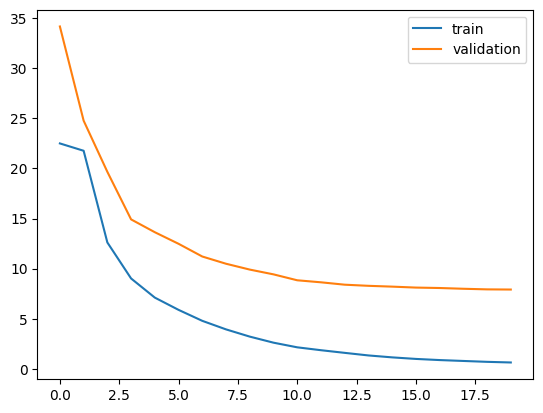

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()